In [1]:
from __future__ import print_function

import lsst.sims.maf
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles

lsst.sims.maf.__version__

'2.13.0.sims-61-g3ee711b3+fffdf3dce1'

# Background

Metrics are computed against OpSim simulations, the outputs of which are stored in SQLite databases.  The latest simulation outputs are avaialable at http://astro-lsst-01.astro.washington.edu:8082.  They're described in https://community.lsst.org/t/january-2020-update-fbs-1-4-runs/4006.  In order to run metrics against a simulation, you need to have downloaded the associate .db file.  In this notebook, we use the simulation database available at http://astro-lsst-01.astro.washington.edu:8082/fbs_db/footprints/footprint_add_mag_cloudsv1.4_10yrs.db.

In [2]:
dbdir = '/sims_maf/'
opsdb = db.OpsimDatabase(dbdir+'fbs_1.5/footprints/footprint_add_mag_cloudsv1.5_10yrs.db')
outDir = 'output_directory' #results from the metrics will be stored here
resultsDb = db.ResultsDb(outDir=outDir)


What information is in the OpSim output?  You can get the names of the columns in the database by running the `columnNames` method on `opsdb`.  The database populates these columns with information about every visit in the simulated cadence.  In order to access this information, we will need to issue a query against the database, as described below.

In [3]:
opsdb.columnNames

{'Proposal': ['proposalId', 'proposalName', 'proposalType'],
 'SummaryAllProps': ['observationId',
  'fieldRA',
  'fieldDec',
  'observationStartMJD',
  'flush_by_mjd',
  'visitExposureTime',
  'filter',
  'rotSkyPos',
  'numExposures',
  'airmass',
  'seeingFwhm500',
  'seeingFwhmEff',
  'seeingFwhmGeom',
  'skyBrightness',
  'night',
  'slewTime',
  'visitTime',
  'slewDistance',
  'fiveSigmaDepth',
  'altitude',
  'azimuth',
  'paraAngle',
  'cloud',
  'moonAlt',
  'sunAlt',
  'note',
  'fieldId',
  'proposalId',
  'block_id',
  'observationStartLST',
  'rotTelPos',
  'moonAz',
  'sunAz',
  'sunRA',
  'sunDec',
  'moonRA',
  'moonDec',
  'moonDistance',
  'solarElong',
  'moonPhase'],
 'info': ['index', 'Parameter', 'Value']}

As described in the sims_maf_contrib Introduction notebook, to run a metric against OpSim output, you need to:
* specify what you want to measure (referred to as the `metric`), e.g. 5-sigma depth
* specify how you want to project the output (referred to as a `slicer`), e.g. a map of the metric on the sky, or a one-dimensional vector ordered by time of observation, or a single number over the whole survey
* specify the subset of the OpSim output that you want to consider (referred to as a `constraint`), e.g. only output for visits in r-band.

Once these are defined, you collect them into a `MetricBundle`, assemble a dictionary (`bundledict`) describing all of yuor `MetricBundles`, associate your `bundledict` with the input simulation database and output results database through a `MetricBundleGroup`, and use the `MetricBundleGroup` to run your metric.  Following the Introduction notebook, here's an example that returns the lowest airmass at which r-band observations were made at each point in the sky, at roughly 1-degree resolution, using the footprint_add_mag_cloudsv1.4_10yrs simulation output:

In [4]:
# metric = the "maximum" of the "airmass" for each group of visits in the slicer
metric1 = metrics.MinMetric('airmass')

# slicer = a grouping or subdivision of visits for the simulated survey
# based on their position on the sky (using a Healpix grid)
slicer1 = slicers.HealpixSlicer(nside=64)

# sqlconstraint = the sql query (or 'select') that selects all visits in r band
sqlconstraint = 'filter = "r"'

# MetricBundle = combination of the metric, slicer, and sqlconstraint
minairmassSky = metricBundles.MetricBundle(metric1, slicer1, sqlconstraint)

# Our bundleDict will contain just this one metric
bundleDict = {'minairmassSky': minairmassSky}

# Group our bundleDict with the input simulation (opsdb) and location for string results (outDir, resultsDb)
group = metricBundles.MetricBundleGroup(
    bundleDict, opsdb, outDir=outDir, resultsDb=resultsDb)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


Finally, run the metric against the simulation:

In [5]:
group.runAll()

Querying database SummaryAllProps with constraint filter = "r" for columns ['airmass', 'fieldDec', 'fieldRA']
Found 492149 visits
Running:  ['minairmassSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


MAF can plot the map of the minimum airmass, the histogram, and the power spectrum:

Plotting figures with "filter = "r"" constraint now.


/data0/lsst_stack/conda/miniconda3-py37_4.8.2/envs/lsst-scipipe-cb4e2dc/lib/python3.7/site-packages/healpy/pixelfunc.py:1583: UserWarning: monopole: 1.23128  dipole: lon: 81.2218, lat: 79.439, amp: 0.24138
  mono, lon, lat, amp


Plotting complete.


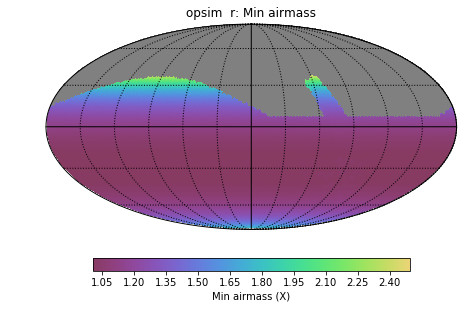

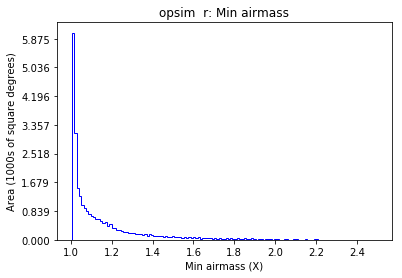

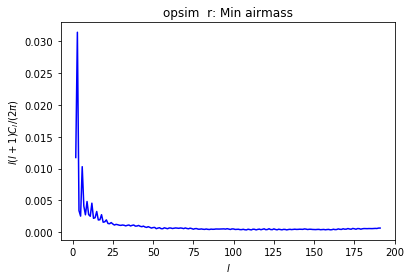

In [6]:
group.plotAll(closefigs=False)

MAF has lots of metric provided in its BaseMetric class.  You can get the list of names of them, as shown in the Writing a New Metric notebook, but they won't be very useful unless you can also see what they do.  Fortunately, the name of the module is also stored in the BaseMetric registry:

In [7]:
# List of provided metrics

for metric, module in zip(metrics.BaseMetric.registry.keys(), metrics.BaseMetric.registry.values()):
    print(metric, module)

PassMetric <class 'lsst.sims.maf.metrics.simpleMetrics.PassMetric'>
Coaddm5Metric <class 'lsst.sims.maf.metrics.simpleMetrics.Coaddm5Metric'>
MaxMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MaxMetric'>
AbsMaxMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMaxMetric'>
MeanMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MeanMetric'>
AbsMeanMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMeanMetric'>
MedianMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MedianMetric'>
AbsMedianMetric <class 'lsst.sims.maf.metrics.simpleMetrics.AbsMedianMetric'>
MinMetric <class 'lsst.sims.maf.metrics.simpleMetrics.MinMetric'>
FullRangeMetric <class 'lsst.sims.maf.metrics.simpleMetrics.FullRangeMetric'>
RmsMetric <class 'lsst.sims.maf.metrics.simpleMetrics.RmsMetric'>
SumMetric <class 'lsst.sims.maf.metrics.simpleMetrics.SumMetric'>
CountUniqueMetric <class 'lsst.sims.maf.metrics.simpleMetrics.CountUniqueMetric'>
UniqueRatioMetric <class 'lsst.sims.maf.metrics.simpleMetrics.UniqueRa

If you want to see the documentation and code for a particular metric, try e.g.:

In [8]:
??lsst.sims.maf.metrics.simpleMetrics.MaxMetric

Init signature:
lsst.sims.maf.metrics.simpleMetrics.MaxMetric(
    col=None,
    metricName=None,
    maps=None,
    units=None,
    metricDtype=None,
    badval=-666,
    maskVal=None,
)
Source:        
class MaxMetric(BaseMetric):
    """Calculate the maximum of a simData column slice.
    """
    def run(self, dataSlice, slicePoint=None):
        return np.max(dataSlice[self.colname])
File:           /data0/lsst_stack/stack/miniconda3-py37_4.8.2-cb4e2dc/Linux64/sims_maf/2.13.0.sims-61-g3ee711b3+fffdf3dce1/python/lsst/sims/maf/metrics/simpleMetrics.py
Type:           MetricRegistry
Subclasses:     


# Science Cases

## Magellanic Clouds

### A 3-D Map of the Magellanic System

We will map structure and detect satellites using MSTO and RR Lyrae as tracers.

We desire:
- Footprint: WFD + SCP, avoiding most crowded parts of Galactic Plane
- Filters: ugriz
- N visits per field: 40 per filter in SCP, + WFD
- Depth: u: 25.6 g: 26.8 r: 26.4 i 25.8 z: 24.9 in SCP, otherwise WFD depth
- Cadence: not strongly constrained, but want spacing for proper motions


#### Metrics

From previous notes:

1.  The total number of visits per filter per field in the WFD + SCP area with Dec < -60, avoiding the Galactic Plane; could be aggregated into total or average number of visits of all fields over all filters
	
Existing metrics in MAF: Nvisits

2.  The average total depth per filter in the fields above

Existing metrics in MAF: 
- CoaddM5 - Coadded depth per healpix, with benchmark value (depending on filter) subtracted.
- fiveSigmaDepth - is this the single-visit depth? (it's ~2 mags shallower than coaddM5)

3.  For a candidate stellar population parametrized by age, metallicity, distance, surface density, and spatial profile, the signal to noise of the population, evaluated as:

    T/sqrt(T^2 + B^2), 

where T is the number of target stars and B the number of foreground contaminant stars plus the number of background unresolved galaxies

Adriano Pieres has a metric similar to this (T/sqrt(B)).

Need to include: contamination filtering (e.g. S/G separation) and proper motion selection

Existing metrics in MAF: 

not much! but possibly relevant to create it, there are:
- skyBrightness
- CoaddM5 / fiveSigmaDepth

4.  Given an input distribution of dwarf satellites, the number that would be detected above a set S/N threshold, evaluated through @3.

5.  Given an input distribution of low surface brightness streams, the number that would be detected above a set S/N threshold, evaluated through @3.


### A Detailed census of variables and transients

We will target periodic and irregular variables, SN light echoes, giant planet transits, microlensing events, and interstellar scintillation.

We desire:

- Footprint: 9 fields on LMC main body, 3 SMC main body fields
- Filters: ugriz
- N visits per field: u: 50 g: 1300 r: 300 i: 300 z: 30 y: 20
- Depth: will be confusion-limited
- Cadence: Two campaigns of 500 15-second consecutive exposure sequences in g for interstellar scintillation; 300 30-second visits in gri spaced roughly logarithmically over 10 years; uzy visits such that reach confusion depth under excellent image quality conditions


#### Metrics


Primary Science: LSST will enable the identification and locations of variable populations in the Clouds using high time and areal coverage, with 2000 visits in each of 12 fields during the 10 years.

Baisc metric: 
- N_visits/300 per main body field in gri


I. Obtain light Curves and periods of all variable objects to Mv=6.5 to map populations

    A. Find all eclipsing binaries (periods of hrs-yrs), Mv=0-6.5

    Existing metrics in MAF: 
    - periodicDetectMetric (for P=0.5-2 days, amp=0.05-1 mag, 21 and 24th mag stars) https://github.com/rhiannonlynne/notebooks/blob/master/periodicity%20check.ipynb

    Metrics needed

    B.  Find all outbursting cataclysmic variables
        B1. New novae and Recurrent novae (outbursts 7 mag in 1-5 yrs), Mv =-7 to -9
        B2. Dwarf novae (outbursts 2-8 mag in weeks to years), Mv = 4.5-5.5

    Existing metrics in MAF: ObservationTriplets, PeriodogramPurity, FieldstarCount ( https://github.com/LSST-nonproject/sims_maf_contrib., Lund et al.2016, PASP, 128,025002)

    Metrics needed

     C.  Find all periodic pulsating variables
          C1. Delta Scuti (periods 0.5-7 hrs), Mv=0.7, amp 0.1-1 mag
          C2. RR Lyrae (periods 0.2-1 day), Mv=0.6, amp 0.2-1.2 mag
          C3. Long P variables (periods 60-400 days), Mv=-4, 0.3-5 mag

    Existing metrics in MAF: 
    - periodicDetectMatric (for Delta Scute, RR Lyr)  https://github.com/rhiannonlynne/notebooks/blob/master/periodicity%20check.ipynb
    
    Metrics needed:
    - coverage for LPV

  II.  Explore light echoes for past SN to probe the physics of explosions (weeks timescale)

    Existing metrics

    Metrics needed

  III.  Use interstellar scintillation to probe invisible baryonic matter (min timescale), need two sets of 500 continuous 15s g filter visits separated by a few months) 

    Existing metrics

    Metrics needed
    - The number of 500-visit campaigns divided by two.

The challenge in this experiment is to detect small stochastic flux fluctuations at the minute scale. The better the photometric resolution, the better the sensitivity to turbulent structures. The turbulence is characterized by the parameter Rdiff, the average transverse separation corresponding to a given column density fluctuation. Rdiff increases when the turbulence decreases.
-> We can distinguish two effects when dividing the number of visits:
- Basically, the precision of the measured modulation index from every scintillation signal scales with the square root of the number of visits.
- The ultimate sensitivity is also downgraded. Considering a Kolmogorov-Smirnov test to distinguish between a stable light-curve from a scintillating one with an error risk of 10% (a reasonable cut), we can connect the number of measurements with the maximum turbulent parameter Rdiff. Assuming the best 0.5% LSST photometric precision, decreasing the number of measurements from 500 to 250 would degrade the ultimate sensitivity from Rdiff max = 13000km down to 10000km.

IV. Find giant planet transits in LMC to probe planet formation under low metallicity (hrs)

    Existing metrics

    Metrics needed


V. Use microlensing events in the Clouds and Galactic halo to probe compact objects (timescales weeks-months)

    Existing metrics

    Metrics needed
    - Largest gap between visits for microlensing
    - The probability that the visit distribution was drawn from a logarithmic distribution